# CS109 Final Project Process Book

## Background & Motivation
Social media and entertainment are such pervasive parts of millennials' lives. We want to study the intersection of these two. Is it possible to predict box office success of film through sentiments expressed on social media? Stay tuned for more!

## Table of Contents
* [CS109 Final Project Process Book](#CS109-Final-Project-Process-Book)
	* [Milestone 1: Scrape and prepare data before thanksgiving](#Milestone-1:-Scrape-and-prepare-data-before-thanksgiving)
		* [Scraping and cleaning Box Office Mojo](#Scraping-and-cleaning-Box-Office-Mojo)
		* [Loading and preparing IMDB review dataset](#Loading-and-preparing-IMDB-review-dataset)
		* [Loading and preparing AFINN dictionary](#Loading-and-preparing-AFINN-dictionary)
	* [Milestone 2: Analysing and visualizing the data](#Milestone-2:-Analysing-and-visualizing-the-data)
		* [Descriptive statistics](#Descriptive-statistics)
		* [Analysis](#Analysis)
        * [Visualization](#Visualization)
	* [Milestone 3: Video and finishing touches](#Milestone-3:-Video-and-finishing-touches)
		* [Screencast video](#Screencast-video)
		* [Website](#Website)
		* [Finishing touches](#Finishing-touches)

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import math

## Milestone 1: Scrape and prepare data before thanksgiving

For our project we will be using data from 3 different sources
 <ul><b>Box Office Mojo (BOM)</b> (http://www.boxofficemojo.com) is a website that aggregates, in a table, a list of all movies released in a year and attributes such as how much it grossed in the opening week, how much it grossed in total and how long it aired for </ul>
 <ul><b>Large Movie Review Dataset</b> (http://ai.stanford.edu/~amaas/data/sentiment/) is a polarized dataset of movie reviews from IMDB prepared by Maas et al from Stanford. The dataset contains 25,000 entries in the training set and 25,000 entries in the test set. </ul>
 <ul><b>AFINN-111 Dictionary</b> (http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=60100) is a dictionary list of 2477 english words and phrases rated for valence with an integer from -5 to 5. Originally prepared by Finn Årup Nielsen</ul><br>
In this first milestone, we will get all the data into a format that we can start running analysis on!

### Scraping and cleaning Box Office Mojo

First we import the `requests` and `BeautifulSoup` libraries to make working with HTTP requests easier, and then easily transfer HTML content to Python data structures.

In [2]:
from bs4 import BeautifulSoup
# The "requests" library makes working with HTTP requests easier
# than the built-in urllib libraries.
import requests

Secondly, we prepare the data frame `movie_df` to store the data that we will scrape from BOM. We give this dataframe 9 columns: <br>
    * ranking: the ranking of the movie in its release year by gross
    * title: movie title
    * gross: how much the movie grossed while in theatres
    * Total_theaters: the total number of theaters that showed this movie
    * opening_gross: how much the movie grossed in the opening weekend (Fri-Sun)
    * opening_theaters: the total number of theaters that showed this movie in the opening weekend (Fri-Sun)
    * open_date: date of opening
    * close_date: date of closing
    * year: year of release

In [3]:
movie_df = pd.DataFrame(columns=['close_date', 'gross', 'open_date', 'opening_gross', 'opening_theaters','ranking','title','total_theaters','year'])

Now we write a function `rowInfoGrabber` that we will call in a loop over the table on the BOM webpage to grab the attributes and save them into the corresponding columns in `movie_df`.

In [4]:
def rowInfoGrabber(r):
    info = []
    # Ranking
    info.append(int(r.find("font").get_text()))
    # Title
    info.append(r.find("a").get_text())
    # Gross
    info.append(int(r.find("td", attrs={"align":"right"}).find("b").get_text().strip("$").replace(",","")))
    '''
    For the next 3 categories, we need to deal with the 2000 Anomaly "Fantasia" where there are missing numbers.
    In this case I have chosen to replace the missing values 'N/A' with the values from 'Final Destination', which
    if right above it in the movie table and differs in gross income by about $1 million, which is a small 
    difference. See the picture below for a snapshot of the anomaly in the movie table from 2000.
    '''
    # Total number of theaters
    if r.find_all("td",attrs={"align":"right"})[1].find("font").get_text().replace(",","") == 'N/A':
        info.append(2587)
    else:
        info.append(int(r.find_all("td",attrs={"align":"right"})[1].find("font").get_text().replace(",","")))
    # Opening Gross
    if r.find_all("td", attrs={"align":"right"})[2].find("font").get_text().strip("$").replace(",","") == 'N/A':
        info.append(10015822)
    else: 
        info.append(int(r.find_all("td", attrs={"align":"right"})[2].find("font").get_text().strip("$").replace(",","")))
    # Opening Number of Theaters
    if r.find_all("td", attrs={"align":"right"})[3].find("font").get_text().replace(",","") == 'N/A':
        info.append(2587)
    else:
        info.append(int(r.find_all("td", attrs={"align":"right"})[3].find("font").get_text().replace(",","")))
    # Date of Opening
    info.append(r.find_all("td", attrs={"align":"right"})[4].find("a").get_text())
    # Date of Closing: Before 2002 they didn't have a "closing" date in their tables. We must account for this.
    if (len(r.find_all("td", attrs={"align":"right"})) <= 5):
        info.append('-')
    else:
        info.append(r.find_all("td", attrs={"align":"right"})[5].find("font").get_text())
    return info

This is the image: <image src=“Example.png”>

In [5]:
fields = ["ranking", "title", "gross", "total_theaters", "opening_gross", "opening_theaters", "open_date", "close_date"]

Finally we're ready to scrape! <br>
Because IMDB was created in 1990, we will scrape that far back in BOM. So we're scraping the past 26 years (1990 - 2015). Also note that because the HTML was changed starting in 2001, our scraping will be a little different before and after then.

In [6]:
%%time
years = [1990 + i for i in range(26)]
for year in years:
    pageText = requests.get("http://www.boxofficemojo.com/yearly/chart/?yr=%(yr)d&p=.htm" % {'yr':year})
    soup = BeautifulSoup(pageText.text, "html.parser")
    movieTable = soup.find("td", attrs={"colspan":"3"})
    movieRows = movieTable.find("table").find_all("tr")[2:102]
    print year
    movie_dicts = [dict(zip(fields, rowInfoGrabber(row))) for row in movieRows]
    year_df = pd.DataFrame(movie_dicts)
    year_df['year'] = year
    movie_df = movie_df.append(year_df, ignore_index=True)
    time.sleep(1)

1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
CPU times: user 12.3 s, sys: 187 ms, total: 12.4 s
Wall time: 43.7 s


In [7]:
movie_df.shape

(2600, 9)

In [8]:
movie_df.head()

,close_date,gross,open_date,opening_gross,opening_theaters,ranking,title,total_theaters,year
0,-,285761243,11/16,17081997,1202,1,Home Alone,2173,1990
1,-,217631306,7/13,12191540,1101,2,Ghost,1766,1990
2,-,184208848,11/9,598257,14,3,Dances with Wolves,1636,1990
3,-,178406268,3/23,11280591,1325,4,Pretty Woman,1811,1990
4,-,135265915,3/30,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990


Because some films do not have a close date, we will have to be careful with the close date!

In [9]:
# if we decide it's worth just dumping the movies with no close_date, we can use the code below
# movie_df=movie_df[movie_df.close_date != '-'].reset_index(drop=True)

Next, we combine the `close_date`, `open_date` and `year` columns into two columns `close_date` and `open_date` that are time series. This will make it easier for us to work with the data in the future. 

In [10]:
# splitting the close_date and open_date into the respective month and day
movie_df['close_month'] = movie_df['close_date'].map(lambda x: '0' if x=='-' else x[:x.find('/')])
movie_df['close_day'] = movie_df['close_date'].map(lambda x: '0' if x=='-' else x[x.find('/')+1:len(x)])
movie_df['open_month'] = movie_df['open_date'].map(lambda x: x[:x.find('/')])
movie_df['open_day'] = movie_df['open_date'].map(lambda x: x[x.find('/')+1:len(x)])

# dropping the old close_date and open_date
movie_df = movie_df.drop('close_date', 1)
movie_df = movie_df.drop('open_date', 1)

# creating an open_year by turning the year column into a string and getting rid of trailing bits
movie_df['open_year'] = movie_df.year.astype(str)
movie_df['open_year'] = movie_df.open_year.map(lambda x: x[:x.find('.')])

# creating a close_year column, by looking at whether the close month is earlier/later than the open month in the year
close_month = movie_df['close_month'].astype(int)
open_month = movie_df['open_month'].astype(int)
year = movie_df['year'].astype(int)
close_year=[]
for i in range (0, len(year)):
    if close_month[i] >= open_month[i]:
        close_year.append(year[i])
    else:
        close_year.append(year[i]+1) 
movie_df['close_year'] = close_year
movie_df['close_year'] = movie_df['close_year'].astype(str)

In [11]:
movie_df.head()

,gross,opening_gross,opening_theaters,ranking,title,total_theaters,year,close_month,close_day,open_month,open_day,open_year,close_year
0,285761243,17081997,1202,1,Home Alone,2173,1990,0,0,11,16,1990,1991
1,217631306,12191540,1101,2,Ghost,1766,1990,0,0,7,13,1990,1991
2,184208848,598257,14,3,Dances with Wolves,1636,1990,0,0,11,9,1990,1991
3,178406268,11280591,1325,4,Pretty Woman,1811,1990,0,0,3,23,1990,1991
4,135265915,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990,0,0,3,30,1990,1991


Let's take a look at the data, now!

In [12]:
movie_df.head()

,gross,opening_gross,opening_theaters,ranking,title,total_theaters,year,close_month,close_day,open_month,open_day,open_year,close_year
0,285761243,17081997,1202,1,Home Alone,2173,1990,0,0,11,16,1990,1991
1,217631306,12191540,1101,2,Ghost,1766,1990,0,0,7,13,1990,1991
2,184208848,598257,14,3,Dances with Wolves,1636,1990,0,0,11,9,1990,1991
3,178406268,11280591,1325,4,Pretty Woman,1811,1990,0,0,3,23,1990,1991
4,135265915,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990,0,0,3,30,1990,1991


Let's take a look at if we can get the run times for each movie!

In [13]:
run_time=[]
for index, row in movie_df.iterrows():
    if row.close_date != None:
        run_time.append(row['close_date']-row['open_date'])
    else: 
        run_time.append('N/A')

AttributeError: 'Series' object has no attribute 'close_date'

In [14]:
movie_df.head()

,gross,opening_gross,opening_theaters,ranking,title,total_theaters,year,close_month,close_day,open_month,open_day,open_year,close_year
0,285761243,17081997,1202,1,Home Alone,2173,1990,0,0,11,16,1990,1991
1,217631306,12191540,1101,2,Ghost,1766,1990,0,0,7,13,1990,1991
2,184208848,598257,14,3,Dances with Wolves,1636,1990,0,0,11,9,1990,1991
3,178406268,11280591,1325,4,Pretty Woman,1811,1990,0,0,3,23,1990,1991
4,135265915,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990,0,0,3,30,1990,1991


Looks like the data is ready for us to use! Let's save this data so we're ready to use it next time. 

In [17]:
! pip install pymongo

In [15]:
# Save the movie Dictionaries corresponding to each row of the BoxOfficeMojo table.
import json # (dong)
# import pymongo
# from bson import json_util

# Make a dictionary out of the dataset for storage in JSON format.
movieSaved = {feature: movie_df[feature].values.tolist() for feature in movie_df.columns.values}
fp = open("allMovies_new.json","w")
json.dump(movieSaved, fp)
fp.close()

### Loading and preparing IMDB review dataset

We have cleaned up our IMDB review dataset in the ipython notebook `New.ipynb`. From that notebook we have been able to save dictionaries of our data, which we will now call. 

In [16]:
with open("train_df_dict.json", "r") as fd:
    train_df_dict = json.load(fd)
with open("test_df_dict.json", "r") as fd:
    test_df_dict = json.load(fd)

In [17]:
train_df = pd.DataFrame(train_df_dict)
test_df = pd.DataFrame(test_df_dict)

The Stanford group distinguishes between train and test because this was relevant for their project. This may prove to be useful later, so we will keep two separate dataframes. However, for our purposes at the moment, we can combine them since the BOM data will serve as our true data set.

In [18]:
IMDB_df = train_df.append(test_df)

We want to figure out which movies from IMDB_df are also present in our BOM DF. So let's get all the movie titles in our BOM table. 

In [19]:
BOM_movie_list = movie_df.title.values.tolist()

Now let's create a mask over IMDB_df, the boolean values of which indicate whether or not a movie is in the BOM list.

In [20]:
movie_mask = [(movie in BOM_movie_list) for movie in IMDB_df.movie_name]

In [21]:
sum(movie_mask)

4111

We can now create out final, relevant IMDB data frame, with only those movies that also appear in the BOM tables from 1990 - 2015. 

In [22]:
IMDB_dftouse=IMDB_df[movie_mask]

Finally we want to save our dictionary of IMDB_dftouse into a JSON file for storage.

In [23]:
IMDB_dftouse_dict = {feature: IMDB_dftouse[feature].values.tolist() for feature in IMDB_dftouse.columns.values}

fp = open("IMDB_dftouse_dict.json","w")
json.dump(IMDB_dftouse_dict, fp)
fp.close()

In [24]:
with open("IMDB_dftouse_dict.json", "r") as fd:
    IMDB_dftouse_dict = json.load(fd)

### Loading and preparing AFINN dictionary

We wil read in the AFINN-111 dictionary from the tab-delimited .txt file and save it into a pandas dataframe `dictionary`. 

In [25]:
words = []
valences = []

with open('AFINN/AFINN-111.txt','rb') as source:
    for line in source:
        fields = line.split('\t')
        words.append(fields[0])
        valences.append(fields[1])
dictionary = pd.DataFrame({'words': words, 'valences':valences})

Because the valences are read in as a string, we will clean it up and change it to an int so it is ready for manipulation. 

In [26]:
dictionary['valences'] = dictionary['valences'].map(lambda x: x if x.find('\n')== -1 else x[:x.find('\n')])
dictionary['valences']=dictionary['valences'].astype(int)

Let's take a look at the dictionary!

In [27]:
dictionary.head()

,valences,words
0,-2,abandon
1,-2,abandoned
2,-2,abandons
3,-2,abducted
4,-2,abduction


Looks like the dictionary is ready for us to use! Let's save it so we have it in the event that anything happens. 

In [28]:
# dictionary.to_csv("dictionary.csv", index=False)
dictionary=pd.read_csv("dictionary.csv")

## Milestone 2: Analysing and visualizing the data

### Descriptive statistics

We're going to reimport our prepared datasets - dictionary.csv (contains the dictionary from the AFINN dataset), and allMovies_new.json (which contains all the reviews that cross over with our BOM data). We will import these as panda dataframes `dictionary` and `IMDB_df` respectively. 

In [29]:
dictionary=pd.read_csv("dictionary.csv")

with open("IMDB_dftouse_dict.json", "r") as fd:
    IMDB = json.load(fd)
IMDB_df = pd.DataFrame(IMDB)

Now we'll import allMoives_new.json. Remember that we still need to convert some of the columns into the datetime type so we'll do that afterwards. 

In [30]:
with open("allMovies_new.json", "r") as fd:
    movie_df = json.load(fd)
    movie_df = pd.DataFrame(movie_df)

In [31]:
# making close_date and open_date by concatenating the year, month and day
import datetime
close_date = []
for index, row in movie_df.iterrows():
    if row.close_day != '0':
        close_date.append(datetime.datetime(int(row.close_year), int(row.close_month), int(row.close_day)))
    else: 
        close_date.append(None)
movie_df['close_date'] = close_date

movie_df['open_date']=movie_df.open_year + '-' + movie_df.open_month + '-' + movie_df.open_day
movie_df['open_date']=movie_df['open_date'].apply(pd.datetools.parse)

# dropping unnecessary columns
movie_df = movie_df.drop('close_day', 1)
movie_df = movie_df.drop('close_month', 1)
movie_df = movie_df.drop('open_day', 1)
movie_df = movie_df.drop('open_month', 1)

Great! Let's take a look at all the dataframes we've created

In [32]:
movie_df

,close_year,gross,open_year,opening_gross,opening_theaters,ranking,title,total_theaters,year,close_date,open_date
0,1991,285761243,1990,17081997,1202,1,Home Alone,2173,1990,None,1990-11-16
1,1991,217631306,1990,12191540,1101,2,Ghost,1766,1990,None,1990-07-13
2,1991,184208848,1990,598257,14,3,Dances with Wolves,1636,1990,None,1990-11-09
3,1991,178406268,1990,11280591,1325,4,Pretty Woman,1811,1990,None,1990-03-23
4,1991,135265915,1990,25398367,2006,5,Teenage Mutant Ninja Turtles,2377,1990,None,1990-03-30
5,1991,122012643,1990,17161835,1225,6,The Hunt for Red October,1817,1990,None,1990-03-02
6,1991,119394840,1990,25533700,2060,7,Total Recall,2131,1990,None,1990-06-01
7,1991,117540947,1990,21744661,2507,8,Die Hard 2: Die Harder,2507,1990,None,1990-07-06
8,1991,103738726,1990,22543911,2332,9,Dick Tracy,2332,1990,None,1990-06-15
9,1991,91457688,1990,7918560,1833,10,Kindergarten Cop,1937,1990,None,1990-12-22


In [33]:
IMDB_df.head()

,movie_id,movie_name,positive,stars,text,url
0,10027,Titanic,True,7,"Sure, Titanic was a good movie, the first time...",http://www.imdb.com/title/tt0120338/usercommen...
1,10028,Titanic,True,10,When I saw this movie I was stunned by what a ...,http://www.imdb.com/title/tt0120338/usercommen...
2,10029,Titanic,True,10,Why do people bitch about this movie and not a...,http://www.imdb.com/title/tt0120338/usercommen...
3,10030,Titanic,True,10,"What's inexplicable? Firstly, the hatred towar...",http://www.imdb.com/title/tt0120338/usercommen...
4,10031,Titanic,True,10,"Previously, I wrote that I loved ""Titanic"", cr...",http://www.imdb.com/title/tt0120338/usercommen...


In [34]:
dictionary.head()

,valences,words
0,-2,abandon
1,-2,abandoned
2,-2,abandons
3,-2,abducted
4,-2,abduction


Now, we want to make a new dataframe `flattened_df` that we can use to run our regressions on. This dataframe will include all the columns in `movie_df` and the extra columns
* number of reviews for the movie in IMDB_df
* average stars from the reviews
* overall ranking

In [35]:
# set index to title
indexed_df = movie_df.set_index("title")

In [36]:
# use groupby to get the review_count and the star_avg
gold = IMDB_df.groupby("movie_name")
review_count = gold.movie_name.count()
star_avg = gold.stars.mean()
positive = gold.positive.mean()

In [37]:
# concatenate the two series into our final dataframe flattened_df
flattened_df = pd.concat([indexed_df, review_count], axis=1, join_axes=[indexed_df.index])
flattened_df.rename(columns={'movie_name': 'review_count'}, inplace=True)
flattened_df = pd.concat([flattened_df, star_avg], axis=1, join_axes=[indexed_df.index])
flattened_df.rename(columns={'stars': 'star_avg'}, inplace=True)
flattened_df = pd.concat([flattened_df, positive], axis=1, join_axes=[indexed_df.index])

Let's take a look at what our dataframe looks like now!

In [38]:
flattened_df.head()

,close_year,gross,open_year,opening_gross,opening_theaters,ranking,total_theaters,year,close_date,open_date,review_count,star_avg,positive
title,,,,,,,,,,,,,
Home Alone,1991,285761243,1990,17081997,1202,1,2173,1990,None,1990-11-16,NaN,NaN,NaN
Ghost,1991,217631306,1990,12191540,1101,2,1766,1990,None,1990-07-13,NaN,NaN,NaN
Dances with Wolves,1991,184208848,1990,598257,14,3,1636,1990,None,1990-11-09,NaN,NaN,NaN
Pretty Woman,1991,178406268,1990,11280591,1325,4,1811,1990,None,1990-03-23,2,1,0
Teenage Mutant Ninja Turtles,1991,135265915,1990,25398367,2006,5,2377,1990,None,1990-03-30,NaN,NaN,NaN


In [39]:
dftouse = flattened_df[~flattened_df['review_count'].map(np.isnan)]
dftouse.shape

(334, 13)

In [40]:
dftouse.head()

,close_year,gross,open_year,opening_gross,opening_theaters,ranking,total_theaters,year,close_date,open_date,review_count,star_avg,positive
title,,,,,,,,,,,,,
Pretty Woman,1991,178406268,1990,11280591,1325,4,1811,1990,None,1990-03-23,2,1.000000,0.0
Dick Tracy,1991,103738726,1990,22543911,2332,9,2332,1990,None,1990-06-15,24,8.875000,1.0
Flatliners,1991,61489265,1990,10034685,1319,18,1483,1990,None,1990-08-10,30,6.966667,0.8
Problem Child,1991,53470891,1990,10026900,1714,21,1769,1990,None,1990-07-27,8,2.500000,0.0
Marked for Death,1991,46044396,1990,11790047,1968,27,1974,1990,None,1990-10-05,3,4.000000,0.0


/Users/alpkaancelik/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


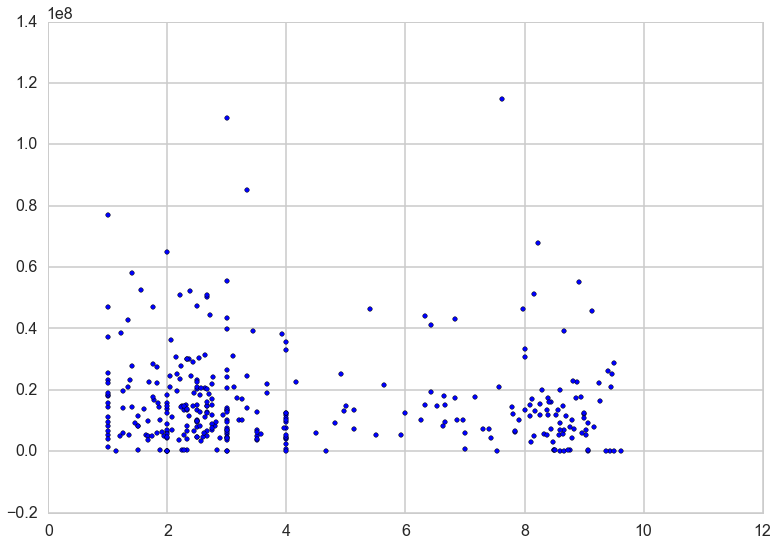

In [41]:
plt.scatter(y=dftouse.opening_gross, x=dftouse.star_avg)

In [42]:
plt.scatter(y=dftouse_four.opening_gross, x=dftouse_four.star_avg,s=dftouse_four.review_count)

NameError: name 'dftouse_four' is not defined

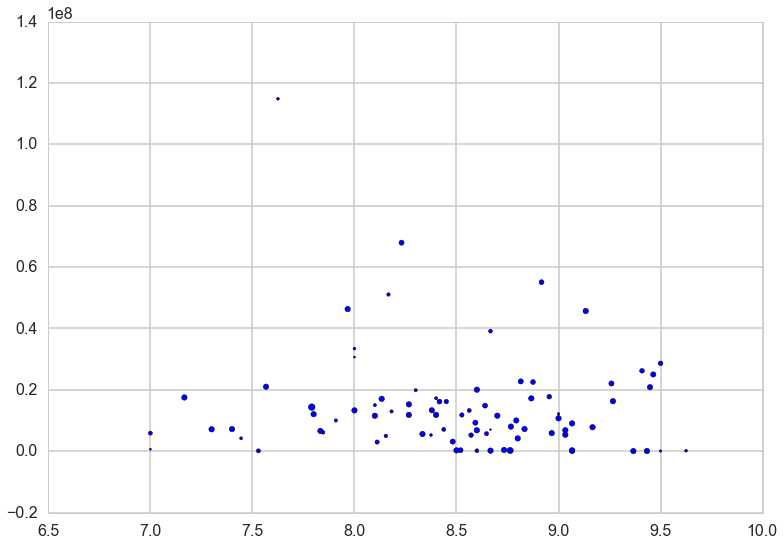

In [160]:
plt.scatter(y=dftouse_seven.opening_gross, x=dftouse_seven.star_avg,s=dftouse_seven.review_count)

In [43]:
dftouse_four = flattened_df[flattened_df['star_avg'] <= 4]
dftouse_seven = flattened_df[flattened_df['star_avg'] >= 7]

In [44]:
dftouse_four.head()

,close_year,gross,open_year,opening_gross,opening_theaters,ranking,total_theaters,year,close_date,open_date,review_count,star_avg,positive
title,,,,,,,,,,,,,
Pretty Woman,1991,178406268,1990,11280591,1325,4,1811,1990,None,1990-03-23,2,1.0,0
Problem Child,1991,53470891,1990,10026900,1714,21,1769,1990,None,1990-07-27,8,2.5,0
Marked for Death,1991,46044396,1990,11790047,1968,27,1974,1990,None,1990-10-05,3,4.0,0
Air America,1991,31053601,1990,8064480,1902,37,1902,1990,None,1990-08-10,5,2.8,0
Internal Affairs,1991,27734391,1990,5043516,975,43,986,1990,None,1990-01-12,2,3.5,0


In [45]:
bobby_ols = ols('opening_gross ~ star_avg',dftouse).fit()
bobby_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          opening_gross   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.465
Date:                Tue, 01 Dec 2015   Prob (F-statistic):              0.227
Time:                        10:57:18   Log-Likelihood:                -6007.5
No. Observations:                 334   AIC:                         1.202e+04
Df Residuals:                     332   BIC:                         1.203e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.769e+07   1.58e+06     11.170      0.000      1.46e+07  2.08e+07
star_avg   -3.764e+05   3.11e+05     -1.210      0.227     -9.88e+05  2.35e+05
==============================================================================
Omnibus:                      203.186   Durbin-Watson:                   1.180
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1582.013
Skew:                           2.499   Prob(JB):                         0.00
Kurtosis:                      12.418   Cond. No.                         9.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
bobby_ols = ols('opening_gross ~ star_avg',dftouse_four).fit()
bobby_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          opening_gross   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.002
Date:                Tue, 01 Dec 2015   Prob (F-statistic):              0.318
Time:                        10:57:22   Log-Likelihood:                -3954.6
No. Observations:                 220   AIC:                             7913.
Df Residuals:                     218   BIC:                             7920.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.973e+07   3.31e+06      5.959      0.000      1.32e+07  2.63e+07
star_avg   -1.297e+06    1.3e+06     -1.001      0.318     -3.85e+06  1.26e+06
==============================================================================
Omnibus:                      126.033   Durbin-Watson:                   1.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              716.861
Skew:                           2.270   Prob(JB):                    2.17e-156
Kurtosis:                      10.589   Cond. No.                         9.19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
bobby_ols = ols('opening_gross ~ star_avg',dftouse_seven).fit()
bobby_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          opening_gross   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.7432
Date:                Tue, 01 Dec 2015   Prob (F-statistic):              0.391
Time:                        10:57:26   Log-Likelihood:                -1553.5
No. Observations:                  86   AIC:                             3111.
Df Residuals:                      84   BIC:                             3116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.719e+07   2.64e+07      1.408      0.163     -1.53e+07  8.97e+07
star_avg   -2.671e+06    3.1e+06     -0.862      0.391     -8.83e+06  3.49e+06
==============================================================================
Omnibus:                       81.009   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              666.603
Skew:                           2.982   Prob(JB):                    1.77e-145
Kurtosis:                      15.266   Cond. No.                         123.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ASK ANDREW WHETHER WE NEED TEST/TRAIN FOR OUR REGRESSION

WORK FLOW 0 GOAL: DESCRIPTIVE STATISTICS <br>
- How many unique movies we have in our IMDB_df
- how many reviews they have each 
- which years do they represent

WORK FLOW 1 GOAL: MAKE A VALENCE SCORE THAT CLOSELY MATCHES STARS
1. Create a valence score for each review
    * summation 
    * average
    * product
1a. Check how good our valence score is by testing on the stars

WORK FLOW 2 GOAL: FIND A REGRESSION MODEL THAT BEST PREDICTS THE FOLLOWING Y VARIABLES
2. Regress on: 
    * opening_gross (controlled for opening weekend)
    * opening_gross/opening_theater
    * total_gross
    * total_gross/total_theateer

    
3. 

In [68]:
#ALP - getting inflation data
inflation = pd.read_csv("inf.csv")

In [70]:
print inflation

      DATE     VALUE
0   1/1/90  5.397956
1   1/1/91  4.234964
2   1/1/92  3.028820
3   1/1/93  2.951657
4   1/1/94  2.607442
5   1/1/95  2.805420
6   1/1/96  2.931204
7   1/1/97  2.337690
8   1/1/98  1.552279
9   1/1/99  2.188027
10  1/1/00  3.376857
11  1/1/01  2.826171
12  1/1/02  1.586032
13  1/1/03  2.270095
14  1/1/04  2.677237
15  1/1/05  3.392747
16  1/1/06  3.225944
17  1/1/07  2.852672
18  1/1/08  3.839100
19  1/1/09 -0.355546
20  1/1/10  1.640043
21  1/1/11  3.156842
22  1/1/12  2.069337
23  1/1/13  1.464833
24  1/1/14  1.622223


### Analysis

### Visualization

## Milestone 3: Video and finishing touches

### Screencast video

### Website

### Finishing touches